# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

## 1. Import necessery libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage import io
import resnet

Using TensorFlow backend.


## 2. Data Pre-processing

In [3]:
# load the normal images, effusion images

DATA_SET_PATH = "/kaggle/input/cxrdata/"
classes = ['effusion', 'nofinding']

effusion_path = os.path.join(DATA_SET_PATH, classes[0], '*')
nofinding_path = os.path.join(DATA_SET_PATH, classes[1], '*')
print(effusion_path)

effusion_files = glob.glob(effusion_path)
nofinding_files = glob.glob(nofinding_path)

print(effusion_files[1])
print(nofinding_files[1])

/kaggle/input/cxrdata/effusion/*
/kaggle/input/cxrdata/effusion/00008087_000.png
/kaggle/input/cxrdata/nofinding/00007675_000.png


### Understanding the data: 

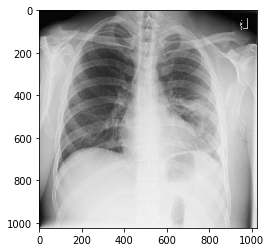

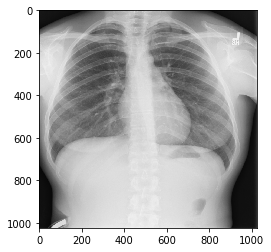

In [4]:
effustion_img  = io.imread(effusion_files[1])
plt.imshow(effustion_img, cmap='gray')

plt.show()
nofinding_img = io.imread(nofinding_files[1])
plt.imshow(nofinding_img, cmap='gray')
plt.show()

In [5]:
print(effustion_img.shape)
print(nofinding_img.shape)

(1024, 1024)
(1024, 1024)


In [6]:
print(len(effusion_files))
print(len(nofinding_files))

107
1000


### 2. Data Agumentation:

In [7]:
import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [8]:
import keras
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                             rotation_range=10, vertical_flip=False, width_shift_range=0, height_shift_range=0)

class AugmentedDataGenerator(keras.utils.Sequence):
    
    def __init__(self, mode='train', ablation=False, disease_cls = ['nofinding', 'effusion'],
                batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        self.mode = mode
        self.disease_cls = disease_cls
        self.no_classes = len(disease_cls)
        self.n_channels = n_channels
        self.dim = dim
        self.batch_size = batch_size
        
        self.labels = {}
        self.list_IDs = []
        
        for i, cls in enumerate(disease_cls):
            files_path = glob.glob(os.path.join(DATA_SET_PATH, cls, '*'))
            brk_point = int(0.8 * len(files_path))
            
            if mode == 'train':
                files_path = files_path[:brk_point]
            else:
                files_path = files_path[brk_point:]
            
            if ablation is not None:
                files_path = files_path[:int(len(files_path)*ablation/100)]
            self.list_IDs += files_path
            self.labels.update({p: i for p in files_path})
            
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, Y = self.__data_generation(list_IDs_temp)
        return X, Y
        
    def preprocess_img(self, img, mode):
        img = (img - img.min())/(img.max() - img.min())
        img = rescale(img, 0.25, multichannel=True, mode='constant')
        
        if mode == 'train':
            if np.random.randn() > 0:
                img = datagen.random_transform(img)
                
        return img
        
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size), dtype=int)
        delete_rows = []
        
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024, 1):
                img = self.preprocess_img(img, self.mode)
                X[i, ] = img
                Y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
        X = np.delete(X, delete_rows, axis=0)
        Y = np.delete(Y, delete_rows, axis=0)
        return X, keras.utils.to_categorical(Y, num_classes=self.no_classes)

In [9]:
AugmentedDataGenerator()

## 3. Ablaation Run

In [10]:
model1 = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
help(model.compile)

NameError: name 'model' is not defined

In [11]:
model1.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
training_generator1 = AugmentedDataGenerator('train', ablation=5)
validation_generator1 = AugmentedDataGenerator('val', ablation=5)
model1.fit_generator(generator=training_generator1, validation_data=validation_generator1, epochs=1)


Epoch 1/1
1/1 [==============================] - 12s 12s/step - loss: 2.5486 - accuracy: 0.0645


## 4. ROC

In [12]:
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *

class RocCallback(Callback):
    def on_train_being(self, logs={}):
        logs['val_auc'] = 0
    
    def on_epoch_end(self, epoch, logs={}):
        y_predicted = []
        y_value = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            tmp = self.model.predict(x_val)
            y_predicted.append(tmp)
            y_value.append(y_val)
        y_predicted = np.concatenate(y_predicted)
        y_value = np.concatenate(y_value)
        roc_auc = roc_auc_score(y_value, y_predicted)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [13]:
help(resnet.ResnetBuilder.build_resnet_18)

Help on function build_resnet_18 in module resnet:

build_resnet_18(input_shape, num_outputs)



In [14]:
model2 = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model2.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

training_generator2 = AugmentedDataGenerator('train', ablation=20)
validation_generator2 = AugmentedDataGenerator('val', ablation=20)

auc_logger = RocCallback()
model2.fit_generator(generator=training_generator2, validation_data=validation_generator2, epochs=5, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - 16s 3s/step - loss: 1.3253 - accuracy: 0.9097 - val_loss: 3.2554 - val_accuracy: 0.9032


NameError: name 'validation_generator' is not defined

In [15]:
from keras import backend as K
from itertools import product
from functools import partial

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())

    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [16]:
model3 = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model3.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator3 = AugmentedDataGenerator('train', ablation=5)
validation_generator3 = AugmentedDataGenerator('val', ablation=5)

model3.fit_generator(generator=training_generator3, validation_data=None, epochs=1)

Epoch 1/1
1/1 [==============================] - 9s 9s/step - loss: 5.7864 - accuracy: 0.0968


#### Decay LR

In [17]:
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [18]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)
bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce, metrics=['accuracy'], optimizer=sgd)

training_generator = AugmentedDataGenerator('train', ablation=90)
validation_generator = AugmentedDataGenerator('val', ablation=90)

decay = DecayLR()
auc_logger = RocCallback()
filepath = 'best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

model.fit_generator(generator=training_generator, validation_data=validation_generator, 
                    callbacks=[auc_logger, decay, checkpoint], epochs=15)

Epoch 1/15
24/24 [==============================] - 55s 2s/step - loss: 2.2726 - accuracy: 0.4873 - val_loss: 1.8594 - val_accuracy: 0.2299

Val AUC for epoch0: 0.6577739529546758

Epoch 00001: val_auc improved from -inf to 0.65777, saving model to best_model.hdf5
Epoch 2/15
24/24 [==============================] - 29s 1s/step - loss: 2.1766 - accuracy: 0.6364 - val_loss: 2.4414 - val_accuracy: 0.8984

Val AUC for epoch1: 0.5075608152531229

Epoch 00002: val_auc did not improve from 0.65777
Epoch 3/15
24/24 [==============================] - 31s 1s/step - loss: 2.0659 - accuracy: 0.6979 - val_loss: 2.7981 - val_accuracy: 0.4278

Val AUC for epoch2: 0.5384083044982699

Epoch 00003: val_auc did not improve from 0.65777
Epoch 4/15
24/24 [==============================] - 32s 1s/step - loss: 2.0693 - accuracy: 0.5663 - val_loss: 2.0484 - val_accuracy: 0.9091

Val AUC for epoch3: 0.631578947368421

Epoch 00004: val_auc did not improve from 0.65777
Epoch 5/15
24/24 [=========================

## 5. Making a Prediction

In [19]:
def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

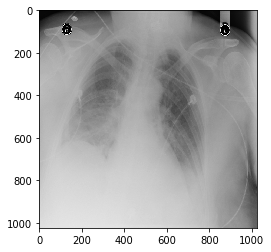

In [20]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('best_model.hdf5')

effusion_path = os.path.join(DATA_SET_PATH, classes[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-22])
plt.imshow(effusion,cmap='gray')

In [21]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

array([[0.5896749, 0.4103251]], dtype=float32)